In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/temperature_series.xlsx")

In [4]:
df.head()

,x,y
0,1891,-0.6291
1,1892,-0.7111
2,1893,-0.7520
3,1894,-0.7008
4,1895,-0.6752


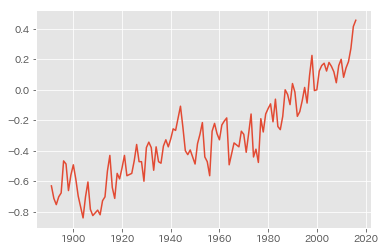

In [5]:
plt.plot(df["x"], df["y"])

In [11]:
stan_model = """
data {
    int T;
    int T_new;
    real Y[T];
}
parameters {
    real mu[T];
    real<lower=0> s_mu;
    real<lower=0> s_Y;
}
model {
    for (t in 2:T) {
        mu[t] ~ normal(mu[t-1], s_mu);
    }
    for (t in 1:T) {
        Y[t] ~ normal(mu[t], s_Y);
    }
}
generated quantities {
    real mu_new;
    real Y_new[T+T_new];
    for (t in 1:T) {
        Y_new[t] = normal_rng(mu[t], s_Y);
    }
    mu_new = normal_rng(mu[T], s_mu);
    Y_new[T+T_new] = normal_rng(mu_new, s_Y);
}
"""

In [12]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1389d8568ff54e1497e5fcdf33d115bb NOW.
C:\Users\s.takai\Anaconda3\envs\tf\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\SF871~1.TAK\AppData\Local\Temp\tmp97f_gtk1\stanfit4anon_model_1389d8568ff54e1497e5fcdf33d115bb_7505817362829939790.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [13]:
stan_data = {
    "T": df.shape[0],
    "T_new": 1,
    "Y": df["y"],
}

In [14]:
fit = sm.sampling(data=stan_data, iter=3000, warmup=1500, seed=123, chains=3)

In [15]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_1389d8568ff54e1497e5fcdf33d115bb.
3 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]   -0.66  8.5e-4   0.05  -0.77   -0.7  -0.66  -0.63  -0.56   3934    1.0
mu[2]   -0.69  8.9e-4   0.05  -0.78  -0.72  -0.69  -0.66   -0.6   2763    1.0
mu[3]   -0.71  1.5e-3   0.05   -0.8  -0.74  -0.71  -0.67  -0.61   1099    1.0
mu[4]   -0.68  1.0e-3   0.05  -0.77  -0.71  -0.68  -0.65  -0.59   1966    1.0
mu[5]   -0.64  8.5e-4   0.04  -0.72  -0.66  -0.64  -0.61  -0.55   2646    1.0
mu[6]   -0.55  2.0e-3   0.05  -0.65  -0.59  -0.55  -0.52  -0.45    641    1.0
mu[7]   -0.55  1.6e-3   0.05  -0.64  -0.58  -0.54  -0.51  -0.45    935    1.0
mu[8]   -0.59  1.0e-3   0.04  -0.68  -0.62  -0.59  -0.56  -0.51   1933    1.0
mu[9]   -0.57  7.6e-4   0.04  -0.66   -0.6  -0.57  -0.54  -0.48   345

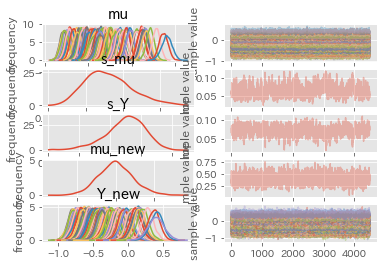

In [16]:
fig = fit.plot()

In [17]:
Y_new_arr = fit.extract("Y_new")["Y_new"]

In [19]:
low_y50, high_y50 = mstats.mquantiles(Y_new_arr, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(Y_new_arr, [0.025, 0.975], axis=0)

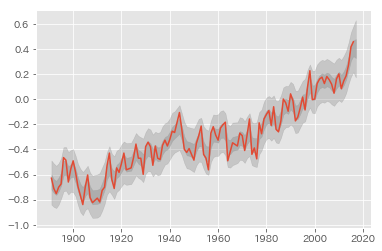

In [20]:
plt.plot(df["x"], df["y"])
x = df["x"].values
x = np.append(x, 2017)
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")